In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import glob
import pickle

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models import transformer as transformer
from models import random_forest_model as random_forest

### LSTM 1, Data Preparation 

In [4]:
journey_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2016_with_0_demand.csv', index_col=0)
journey_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017_with_0_demand.csv', index_col=0)
journey_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2018_with_0_demand.csv', index_col=0)
journey_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2019_with_0_demand.csv', index_col=0)

In [5]:
journey_train = pd.concat([journey_16, journey_17, journey_18])
journey_test = journey_19.copy()

In [6]:
# Scaling
total_df = pd.concat([journey_train, journey_test])
input_feature = total_df.values 
scaler = MinMaxScaler(feature_range=(0, 1))
input_data = scaler.fit_transform(input_feature)

# Now split the scaled data back into training and testing data
train_size = len(journey_train)
journey_train_scaled = input_data[:train_size]
journey_test_scaled = input_data[train_size:]

In [7]:
demand_index = total_df.columns.get_loc('demand')
lookback = 96
X_train = []
Y_train = []
X_test = []
Y_test = []


# Borough-specific Multi-series LSTM model -> single LSTM model on multiple time series (one for each borough).
# This is a Borough-specific Multi-series LSTM model designed to forecast bike sharing demand for each borough in London separately. By treating each borough's data as an individual time series, the model can learn unique temporal patterns specific to each borough, potentially providing more accurate predictions.
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    mask_train = journey_train['start_borough_' + borough] == 1
    mask_test = journey_test['start_borough_' + borough] == 1
    
    borough_data_train = journey_train_scaled[mask_train.values]
    borough_data_test = journey_test_scaled[mask_test.values]
    
    for i in range(lookback, len(borough_data_train)):
        X_train.append(borough_data_train[i-lookback:i, :])
        # We want to predict demand so the output should be from the 'demand' column
        Y_train.append(borough_data_train[i, demand_index])  

    for i in range(lookback, len(borough_data_test)):
        X_test.append(borough_data_test[i-lookback:i, :])
        # We want to predict demand so the output should be from the 'demand' column
        Y_test.append(borough_data_test[i, demand_index])  

# Convert your lists to numpy arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

# Print shapes
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(313596, 96, 105) (313596,)
(103644, 96, 105) (103644,)


### LSTM 1, with 0 demand

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers

lstm_model = Sequential()
lstm_model.add(LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
lstm_model.add(LSTM(units=30, return_sequences= True))
lstm_model.add(LSTM(units=30))
lstm_model.add(Dense(units=1))
lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 96, 30)            16320     
                                                                 
 lstm_4 (LSTM)               (None, 96, 30)            7320      
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 30,991
Trainable params: 30,991
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = lstm_model.fit(X_train, Y_train, epochs = 2, batch_size = 32, 
                    validation_split= 0.2, 
                    callbacks = EarlyStopping(monitor='val_loss', patience = 5))

Epoch 1/2
7840/7840 [==============================] - 704s 89ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 2/2
7840/7840 [==============================] - 653s 83ms/step - loss: 3.6132e-04 - val_loss: 1.7314e-04


In [20]:
# save model and history

lstm_model.save('../models/lstm_model.h5')

with open('../models/lstm_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [3]:
# Load model and history

with open('../models/lstm_history.pkl', 'rb') as f:
    history = pickle.load(f)

#load model
lstm_model = load_model('../models/lstm_model.h5')

2023-06-22 10:28:45.366703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
predicted_lstm = lstm_model.predict(X_test)
print("Model Evaluation: ", lstm_model.evaluate(X_test, Y_test))

3239/3239 [==============================] - 60s 18ms/step - loss: 2.5992e-04
Model Evaluation:  0.0002599231374915689


In [22]:
# Inverse transform  original data
dummy_array = np.zeros_like(input_data)
dummy_array[-predicted_lstm.shape[0]:, demand_index] = predicted_lstm.ravel()
predicted_lstm_inv = scaler.inverse_transform(dummy_array)[:, demand_index]

dummy_array[-Y_test.shape[0]:, demand_index] = Y_test.ravel()
Y_test_inv = scaler.inverse_transform(dummy_array)[:, demand_index]


In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluation
mae = mean_absolute_error(Y_test_inv, predicted_lstm_inv)
rmse = mean_squared_error(Y_test_inv, predicted_lstm_inv, squared=False)
r_squared = r2_score(Y_test_inv, predicted_lstm_inv)

print('Evaluation')
print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

Evaluation
MAE:  4.606300347441374
RMSE:  13.999042506437524
R2:  0.9699138875326133


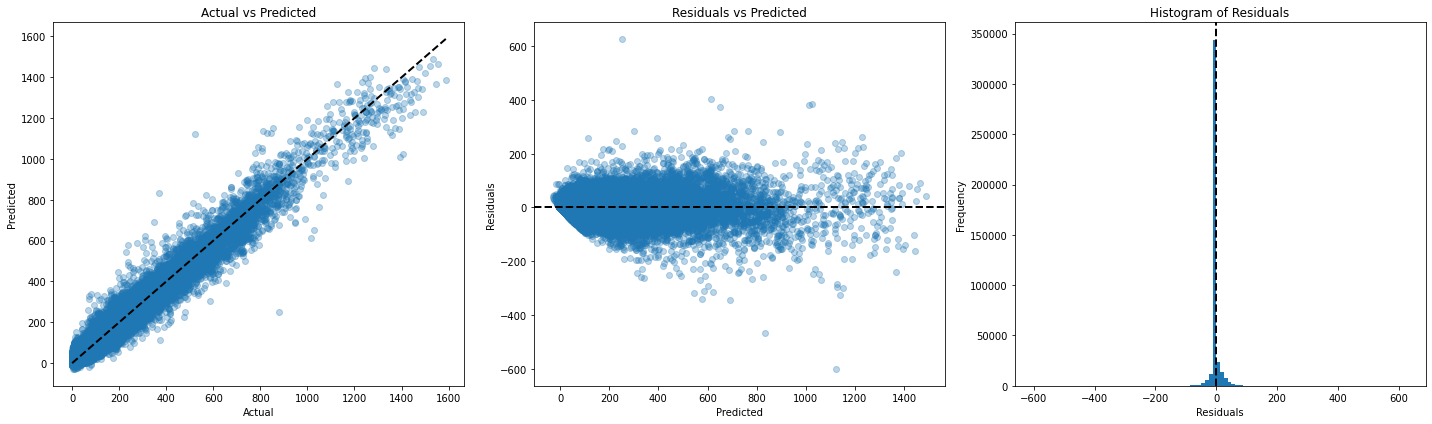

: 

In [24]:
random_forest.evaluation_vis(Y_test_inv, predicted_lstm_inv.reshape(-1))

In [17]:
from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt

feature_names = X_train.columns

ale = ALE(lstm_model.predict, feature_names=feature_names, target_names=['demand'])

x_test_np = X_test.values

# Convert feature names to indices
feature_indices = [list(X_test.columns).index(name) for name in feature_names]

rf_exp = ale.explain(X_test.values)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
import numpy as np

def ale_plot(selected_features, height, spacing, title):

    # Convert the feature names to indices
    selected_feature_indices = [list(x_test.columns).index(name) for name in selected_features]

    nrows = int(np.ceil(len(selected_features) / 6))
    ncols = 6

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, height))

    # Flatten the axes array in case it's 2D (when you have more than one row)
    axs = axs.flatten()

    for ax, feature_index in zip(axs, selected_feature_indices):
        plot_ale(rf_exp, features=[feature_index], ax=ax)

        # set another y-axis scale for hour feature
        if feature_index in [1, 19, 20]:
            ax.set_ylabel('ALE (large scale!)')
            ax.set_ylim([-130,130])
        else:
            ax.set_ylim([-31,31])

    # Disable remaining axes
    for ax in axs[len(selected_features):]:
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=spacing)
    plt.suptitle(f'ALE plot for {title}')
    plt.show()


temporal_features = ['hour', 'part_of_day', 'day_of_week', 'day_of_month', 'day_of_year', 'is_weekend', 'month', 'season', 'bank_holiday']
ale_plot(temporal_features, 8, 0.92, 'temporal features')

In [ ]:
# visualisation: pred vs actual
random_forest.evaluation_actual_vs_predicted(Y_test, predicted_lstm, journey_test, 'All_Boroughs', 'model_random_forest')

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

### LSTM 2, Data Preparation

In [2]:
journey_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2016_with_0_demand.csv', index_col=0)
journey_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017_with_0_demand.csv', index_col=0)
journey_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2018_with_0_demand.csv', index_col=0)
journey_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2019_with_0_demand.csv', index_col=0)

In [3]:
journey_train = pd.concat([journey_16, journey_17, journey_18])
journey_test = journey_19.copy()

In [4]:
borough_cols = ['start_borough_Hackney', 'start_borough_Islington', 'start_borough_City of London', 'start_borough_Westminster', 'start_borough_Tower Hamlets', 'start_borough_Kensington and Chelsea', 'start_borough_Camden', 'start_borough_Hammersmith and Fulham', 'start_borough_Lambeth', 'start_borough_Wandsworth', 'start_borough_Southwark', 'start_borough_Newham']
journey_train_ma_lag = pd.DataFrame()
journey_test_ma_lag = pd.DataFrame()

for borough in borough_cols:
    # select the data for the current borough
    borough_data_train = journey_train[journey_train[borough] == True].copy()
    borough_data_test = journey_test[journey_test[borough] == True].copy()

    # add moving average features to train data
    borough_data_train['demand_ma_3h'] = borough_data_train['demand'].rolling(3).mean()
    borough_data_train['demand_ma_8h'] =  borough_data_train['demand'].rolling(8).mean()
    borough_data_train['demand_ma_24h'] = borough_data_train['demand'].rolling(24).mean()

    # add lagged demand features to train data
    borough_data_train['demand_lag_1h'] = borough_data_train['demand'].shift(1)
    borough_data_train['demand_lag_8h'] = borough_data_train['demand'].shift(8)
    borough_data_train['demand_lag_24h'] = borough_data_train['demand'].shift(24)
    borough_data_train['demand_lag_1w'] = borough_data_train['demand'].shift(24*7)

    # if there is no data for the first x hours, set actual demand as moving average
    borough_data_train['demand_ma_3h'].fillna(borough_data_train['demand'], inplace=True)
    borough_data_train['demand_ma_8h'].fillna(borough_data_train['demand'], inplace=True)
    borough_data_train['demand_ma_24h'].fillna(borough_data_train['demand'], inplace=True)
    borough_data_train['demand_lag_1h'].fillna(borough_data_train['demand'], inplace=True)
    borough_data_train['demand_lag_8h'].fillna(borough_data_train['demand'], inplace=True)
    borough_data_train['demand_lag_24h'].fillna(borough_data_train['demand'], inplace=True)
    borough_data_train['demand_lag_1w'].fillna(borough_data_train['demand'], inplace=True)

    # append the data for the current borough to the new DataFrame
    journey_train_ma_lag = journey_train_ma_lag.append(borough_data_train)

    # add moving average features to test data
    borough_data_test['demand_ma_3h'] = borough_data_test['demand'].rolling(3).mean()
    borough_data_test['demand_ma_8h'] =  borough_data_test['demand'].rolling(8).mean()
    borough_data_test['demand_ma_24h'] = borough_data_test['demand'].rolling(24).mean()

    # add lagged demand features to test data
    borough_data_test['demand_lag_1h'] = borough_data_test['demand'].shift(1)
    borough_data_test['demand_lag_8h'] = borough_data_test['demand'].shift(8)
    borough_data_test['demand_lag_24h'] = borough_data_test['demand'].shift(24)
    borough_data_test['demand_lag_1w'] = borough_data_test['demand'].shift(24*7)

    # if there is no data for the first x hours, set actual demand as moving average
    borough_data_test['demand_ma_3h'].fillna(borough_data_test['demand'], inplace=True)
    borough_data_test['demand_ma_8h'].fillna(borough_data_test['demand'], inplace=True)
    borough_data_test['demand_ma_24h'].fillna(borough_data_test['demand'], inplace=True)
    borough_data_test['demand_lag_1h'].fillna(borough_data_test['demand'], inplace=True)
    borough_data_test['demand_lag_8h'].fillna(borough_data_test['demand'], inplace=True)
    borough_data_test['demand_lag_24h'].fillna(borough_data_test['demand'], inplace=True)
    borough_data_test['demand_lag_1w'].fillna(borough_data_test['demand'], inplace=True)

    # append the data for the current borough to the new DataFrame
    journey_test_ma_lag = journey_test_ma_lag.append(borough_data_test)


journey_train_ma_lag.reset_index(drop=True, inplace=True)
journey_test_ma_lag.reset_index(drop=True, inplace=True)

In [5]:
# Scaling
total_df = pd.concat([journey_train_ma_lag, journey_test_ma_lag])
input_feature = total_df.values 
scaler = MinMaxScaler(feature_range=(0, 1))
input_data = scaler.fit_transform(input_feature)

# Now split the scaled data back into training and testing data
train_size = len(journey_train_ma_lag)
journey_train_ma_lag_scaled = input_data[:train_size]
journey_test_ma_lag_scaled = input_data[train_size:]

In [6]:
demand_index = total_df.columns.get_loc('demand')
lookback = 60
X_train = []
Y_train = []
X_test = []
Y_test = []


# Borough-specific Multi-series LSTM model -> single LSTM model on multiple time series (one for each borough).
# This is a Borough-specific Multi-series LSTM model designed to forecast bike sharing demand for each borough in London separately. By treating each borough's data as an individual time series, the model can learn unique temporal patterns specific to each borough, potentially providing more accurate predictions.
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    mask_train = journey_train_ma_lag['start_borough_' + borough] == 1
    mask_test = journey_test_ma_lag['start_borough_' + borough] == 1
    
    borough_data_train = journey_train_ma_lag_scaled[mask_train.values]
    borough_data_test = journey_test_ma_lag_scaled[mask_test.values]
    
    for i in range(lookback, len(borough_data_train)):
        X_train.append(borough_data_train[i-lookback:i, :])
        # We want to predict demand so the output should be from the 'demand' column
        Y_train.append(borough_data_train[i, demand_index])  

    for i in range(lookback, len(borough_data_test)):
        X_test.append(borough_data_test[i-lookback:i, :])
        # We want to predict demand so the output should be from the 'demand' column
        Y_test.append(borough_data_test[i, demand_index])  

# Convert your lists to numpy arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

# Print shapes
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(314028, 60, 112) (314028,)
(104076, 60, 112) (104076,)


### LSTM 2, with lag features

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers

lstm_model = Sequential()
lstm_model.add(LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
lstm_model.add(LSTM(units=30, return_sequences= True))
lstm_model.add(LSTM(units=30))
lstm_model.add(Dense(units=1))
lstm_model.summary()


2023-06-21 23:38:41.952462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 30)            17160     
                                                                 
 lstm_1 (LSTM)               (None, 60, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31,831
Trainable params: 31,831
Non-trainable params: 0
_________________________________________________________________


In [8]:
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = lstm_model.fit(X_train, Y_train, epochs = 2, batch_size = 32, 
                    validation_split= 0.2, 
                    callbacks = EarlyStopping(monitor='val_loss', patience = 5))

Epoch 1/2
7851/7851 [==============================] - 405s 51ms/step - loss: 0.0014 - val_loss: 3.2236e-04
Epoch 2/2
7851/7851 [==============================] - 2870s 366ms/step - loss: 3.2585e-04 - val_loss: 1.9689e-04


In [9]:
# save model and history

lstm_model.save('../models/lstm_model_2.h5')

with open('../models/lstm_history_2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [10]:
predicted_lstm = lstm_model.predict(X_test)
print("Model Evaluation: ", lstm_model.evaluate(X_test, Y_test))

3253/3253 [==============================] - 138s 42ms/step - loss: 2.8083e-04
Model Evaluation:  0.0002808283024933189


In [11]:
# Inverse transform  original data
dummy_array = np.zeros_like(input_data)
dummy_array[-predicted_lstm.shape[0]:, demand_index] = predicted_lstm.ravel()
predicted_lstm_inv = scaler.inverse_transform(dummy_array)[:, demand_index]

dummy_array[-Y_test.shape[0]:, demand_index] = Y_test.ravel()
Y_test_inv = scaler.inverse_transform(dummy_array)[:, demand_index]


In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluation
mae = mean_absolute_error(Y_test_inv, predicted_lstm_inv)
rmse = mean_squared_error(Y_test_inv, predicted_lstm_inv, squared=False)
r_squared = r2_score(Y_test_inv, predicted_lstm_inv)

print('Evaluation')
print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

Evaluation
MAE:  4.512364278254737
RMSE:  14.58141446716979
R2:  0.9675029311217634


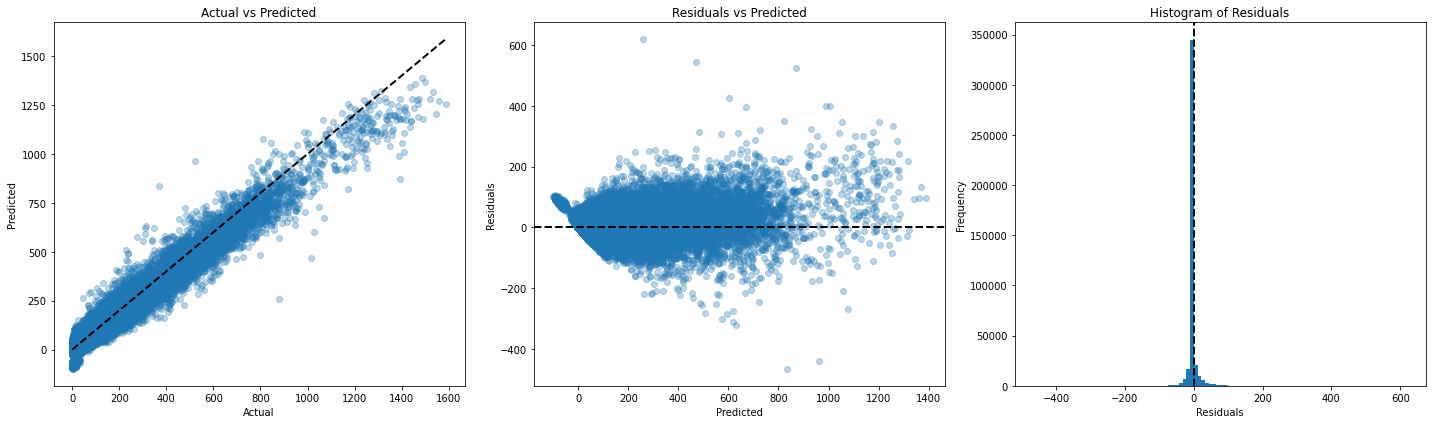

In [13]:
random_forest.evaluation_vis(Y_test_inv, predicted_lstm_inv.reshape(-1))

### Transformer

In [2]:
journey_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2016_with_0_demand.csv', index_col=0)
journey_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017_with_0_demand.csv', index_col=0)
journey_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2018_with_0_demand.csv', index_col=0)
journey_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2019_with_0_demand.csv', index_col=0)

journey_train = pd.concat([journey_16, journey_17, journey_18])
journey_test = journey_19.copy()

# Scaling
total_df = pd.concat([journey_train, journey_test])
input_feature = total_df.values 
scaler = MinMaxScaler(feature_range=(0, 1))
input_data = scaler.fit_transform(input_feature)

# Now split the scaled data back into training and testing data
train_size = len(journey_train)
journey_train_scaled = input_data[:train_size]
journey_test_scaled = input_data[train_size:]

demand_index = total_df.columns.get_loc('demand')
lookback = 96
X_train = []
Y_train = []
X_test = []
Y_test = []


# Borough-specific Multi-series LSTM model -> single LSTM model on multiple time series (one for each borough).
# This is a Borough-specific Multi-series LSTM model designed to forecast bike sharing demand for each borough in London separately. By treating each borough's data as an individual time series, the model can learn unique temporal patterns specific to each borough, potentially providing more accurate predictions.
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    mask_train = journey_train['start_borough_' + borough] == 1
    mask_test = journey_test['start_borough_' + borough] == 1
    
    borough_data_train = journey_train_scaled[mask_train.values]
    borough_data_test = journey_test_scaled[mask_test.values]
    
    for i in range(lookback, len(borough_data_train)):
        X_train.append(borough_data_train[i-lookback:i, :])
        # We want to predict demand so the output should be from the 'demand' column
        Y_train.append(borough_data_train[i, demand_index])  

    for i in range(lookback, len(borough_data_test)):
        X_test.append(borough_data_test[i-lookback:i, :])
        # We want to predict demand so the output should be from the 'demand' column
        Y_test.append(borough_data_test[i, demand_index])  

# Convert your lists to numpy arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

# Print shapes
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(313596, 96, 105) (313596,)
(103644, 96, 105) (103644,)


In [ ]:
tr_model = transformer.Transformer()
tr_model.train(X_train, Y_train)

In [ ]:
# save model and history

tr_model.model.save('../models/tranformer_model.h5')

In [ ]:
predicted_tr = tr_model.predict(X_test)

In [7]:
# Inverse transform  original data
dummy_array = np.zeros_like(input_data)
dummy_array[-predicted_tr.shape[0]:, demand_index] = predicted_tr.ravel()
predicted_tr_inv = scaler.inverse_transform(dummy_array)[:, demand_index]

dummy_array[-Y_test.shape[0]:, demand_index] = Y_test.ravel()
Y_test_inv = scaler.inverse_transform(dummy_array)[:, demand_index]


In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluation
mae = mean_absolute_error(Y_test_inv, predicted_tr_inv)
rmse = mean_squared_error(Y_test_inv, predicted_tr_inv, squared=False)
r_squared = r2_score(Y_test_inv, predicted_tr_inv)

print('Evaluation')
print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

Evaluation
MAE:  5.987470258906309
RMSE:  22.99890016918649
R2:  0.9187948549522943


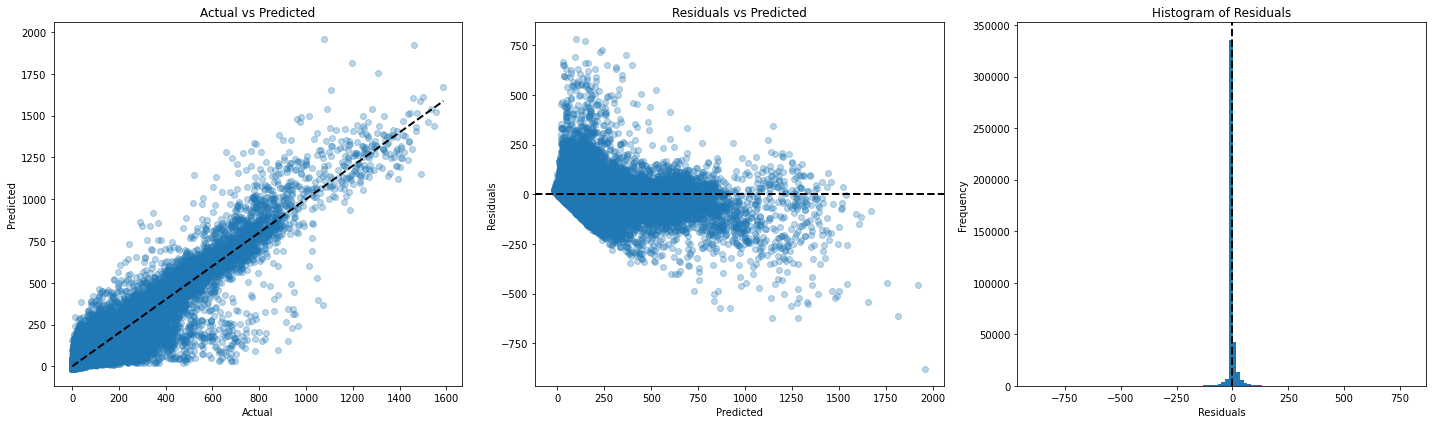

In [9]:
# evaluation visualisation
random_forest.evaluation_vis(Y_test_inv, predicted_tr_inv)